# Importing+Installing Libraries

In [ ]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input, Conv2DTranspose, Reshape, LeakyReLU, MaxPool2D, BatchNormalization, ReLU



physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Data Preprocessing

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images-127.5)/127.5



11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(32)

# Creating the Models

## Discriminator

In [ ]:
discriminator = tf.keras.Sequential(
    [
        Input(shape=(28, 28, 1)),

        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(),

        Conv2D(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(),


        Dropout(0.1),
        Flatten(),
        Dense(1, activation="tanh"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       2176      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         524544    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                     

## Generator

In [ ]:

latent_dim = 784
generator = tf.keras.Sequential(
    [
        Dense(7 * 7 * 256, input_shape = (latent_dim, )),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding="same", use_bias=False, activation="relu"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),

        Conv2DTranspose(64, kernel_size=4, strides=(2,2), padding="same", use_bias=False, activation="relu"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(1, kernel_size=5, padding="same", activation="tanh", use_bias=False),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             9847040   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      524288    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       13

# Training

## Generating Optimization and Loss Functions


In [ ]:
def discriminator_loss(real_predictions, fake_predictions):
  loss = tf.keras.losses.BinaryCrossentropy()
  real_loss = loss(tf.ones_like(real_predictions), real_predictions)
  fake_loss = loss(tf.zeros_like(fake_predictions), fake_predictions)
  return real_loss + fake_loss

discOpt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [ ]:
def generator_loss(fake_predictions):
  loss = tf.keras.losses.BinaryCrossentropy()
  return loss(tf.ones_like(fake_predictions), fake_predictions)

genOpt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

## Training Process

In [ ]:
for epoch in range(10):
  for idx, batch in enumerate(tqdm(dataset)):

    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:


      
      noise = tf.random.normal(shape = (batch_size, latent_dim))
      fake_images = generator(noise)
      real_predictions = discriminator(batch)
      fake_predictions = discriminator(fake_images)

      discLoss = discriminator_loss(real_predictions, fake_predictions)
      genLoss = generator_loss(fake_predictions)

      discGrad = disc_tape.gradient(discLoss, discriminator.trainable_weights)
      genGrad = gen_tape.gradient(genLoss, generator.trainable_weights)

      discOpt.apply_gradients(zip(discGrad, discriminator.trainable_weights))
      genOpt.apply_gradients(zip(genGrad, generator.trainable_weights))

    if idx % 100 == 0:
      img = tf.keras.preprocessing.image.array_to_img(fake_images[0])
      img.save("Folder/epoch:{}_idx:{}.png".format(epoch, idx))


100%|██████████| 1875/1875 [01:22<00:00, 22.61it/s]


# Visualizing Results and Saving Weights

In [ ]:

def show(images):

    # <something gets done here>
    plt.figure()
    plt.imshow(images)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


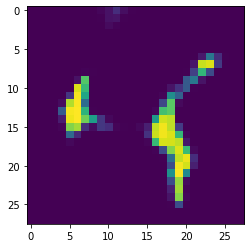

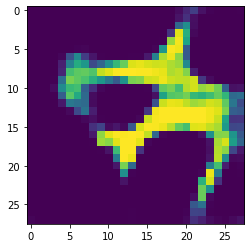

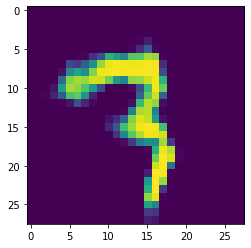

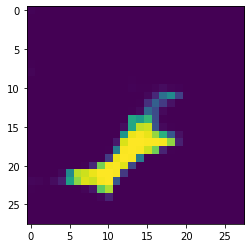

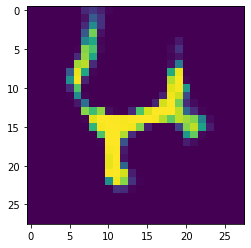

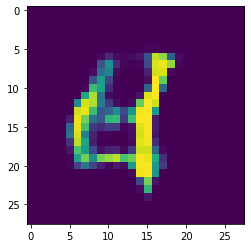

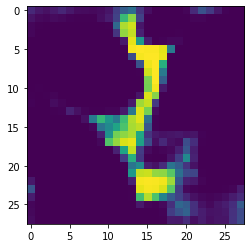

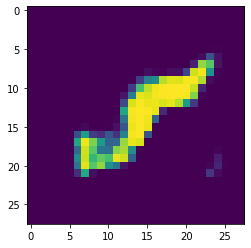

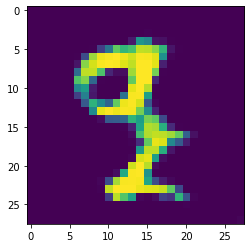

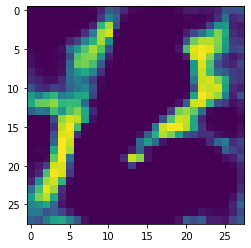

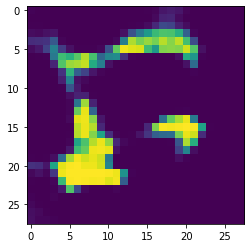

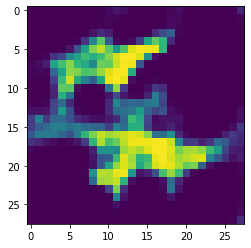

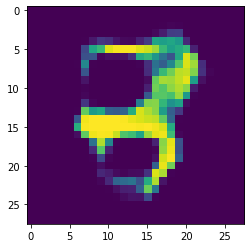

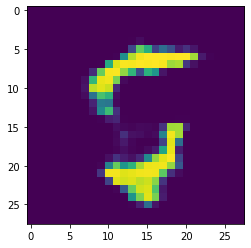

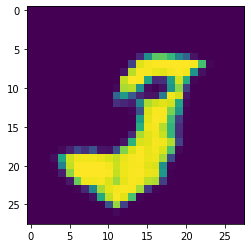

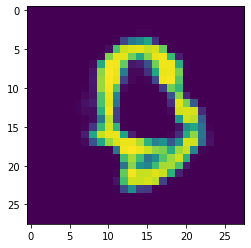

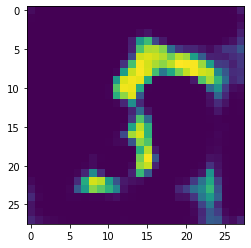

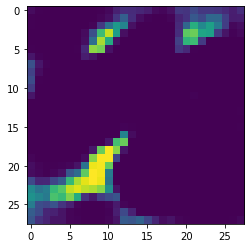

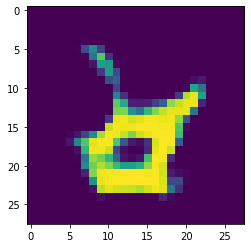

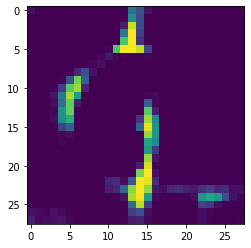

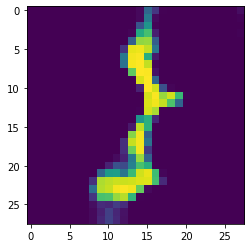

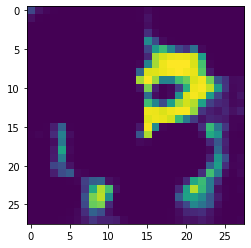

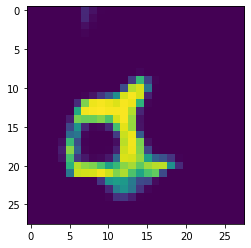

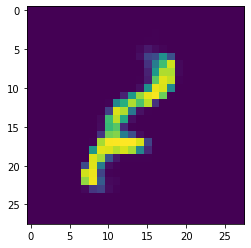

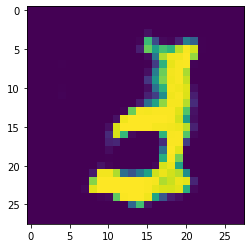

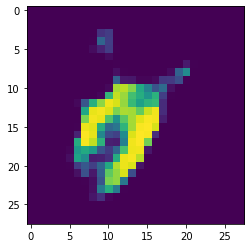

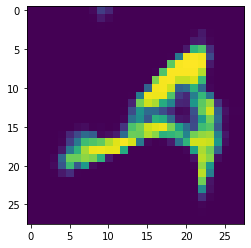

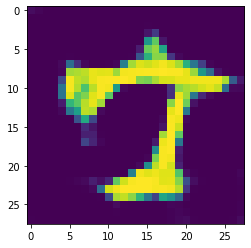

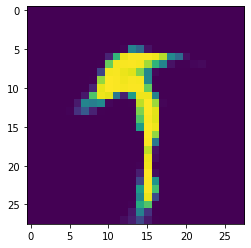

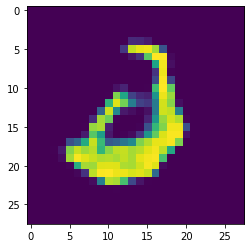

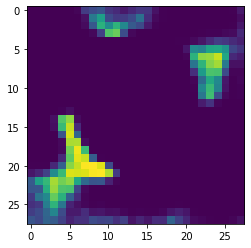

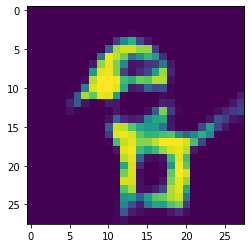

In [ ]:
img = np.array(generator(tf.random.normal(shape = (batch_size, latent_dim))))
for x in range(len(img)):
  show(np.array(img[x]).reshape((28,28)))


In [ ]:
discriminator.save_weights("/content/discriminator")

In [ ]:
generator.save_weights("/content/generator")